# Investigating the impact of moderator interventions

In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox

import tasks.stats
import tasks.postprocessing
import tasks.graphs

In [ ]:
sns.set(
    style="whitegrid",
    font_scale=1.5,
    font="Times New Roman",
    context="paper",
    palette="colorblind",
)

In [ ]:
from tasks.constants import *


TOXICITY_TICKS = np.arange(1, 6, 1)
YTICKS_LIST = [TOXICITY_TICKS, TOXICITY_TICKS]
VMIN_TOXICITY = -1
VMAX_TOXICITY = 1

## Preprocessing

In [ ]:
full_df = tasks.postprocessing.get_main_dataset()
full_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened
0,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",2,4,False
1,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",4,5,False
2,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",3,4,False
3,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",3,4,False
4,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",4,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57470,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Constr. Comms,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
57471,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Constr. Comms,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
57472,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Constr. Comms,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
57473,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Constr. Comms,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False


## When do moderators intervene?

In [ ]:
df_unique = full_df[full_df["conv_variant"] != "No Moderator"].drop_duplicates(
    subset=["message_id"]
)

moderator_interventions = (
    df_unique[df_unique["is_moderator"]].groupby("conv_id").size()
)
conv_variants = (
    df_unique[["conv_id", "conv_variant"]]
    .drop_duplicates()
    .set_index("conv_id")
)
intervention_df = moderator_interventions.to_frame(
    name="moderator_interventions"
).join(conv_variants, how="left")

intervention_df["intervention_pct"] = (
    intervention_df["moderator_interventions"] / intervention_df["moderator_interventions"].max()
) * 100

/tmp/ipykernel_61570/2049281029.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["conv_variant", "bin"])


Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intervention_count.png


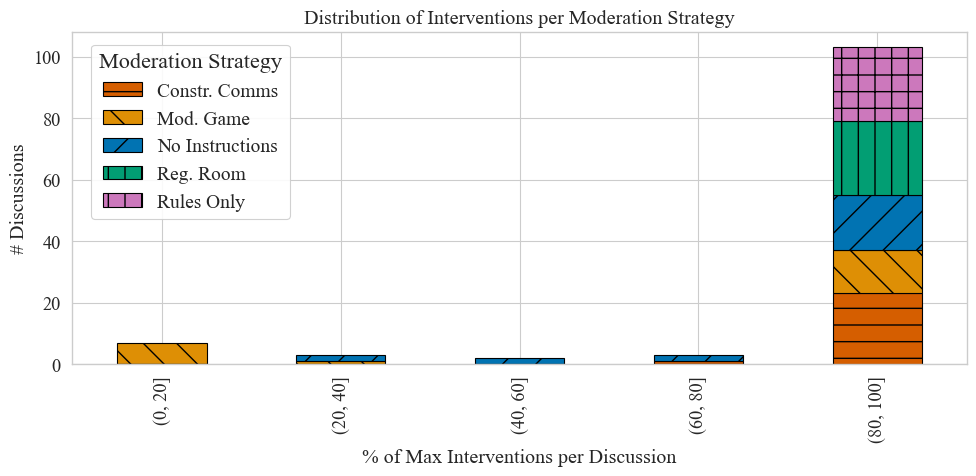

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Bin the intervention percentages
binned_df = (
    intervention_df.assign(
        bin=pd.cut(
            intervention_df["intervention_pct"],
            bins=range(1, 11) * 10,
            right=True,
        )
    )
    .groupby(["conv_variant", "bin"])
    .size()
    .unstack(fill_value=0)
    .T  # Bins as rows, strategies as columns
)

# Step 2: Create color and hatch mappings
strategies = binned_df.columns
colors = [palette_dict[s] for s in strategies]
    hatches = [hatch_dict[s] for s in strategies]

# Step 3: Plot as stacked bar chart
fig, ax = plt.subplots(figsize=(10, 5))

bar_containers = binned_df.plot(
    kind="bar", stacked=True, ax=ax, color=colors, edgecolor="black"
)

# Step 4: Apply hatches manually to each patch
for bar_container, hatch in zip(bar_containers.containers, hatches):
    for patch in bar_container:
        patch.set_hatch(hatch)
        patch.set_edgecolor("black")

# Step 5: Labels and legend
ax.set_xlabel("% of Max Interventions per Discussion")
ax.set_ylabel("# Discussions")
ax.set_title("Distribution of Interventions per Moderation Strategy")

# Custom legend with hatches
from matplotlib.patches import Patch

legend_patches = [
    Patch(
        facecolor=colors[i],
        hatch=hatches[i],
        edgecolor="black",
        label=strategy,
    )
    for i, strategy in enumerate(strategies)
]
ax.legend(
    handles=legend_patches,
    title="Moderation Strategy",
    loc="upper left",
    bbox_to_anchor=(0.01, 0.99),
    frameon=True,
    framealpha=0.9,
    fontsize=14,
    title_fontsize=16,
)

plt.tight_layout()
tasks.graphs.save_plot(GRAPH_OUTPUT_DIR / "intervention_count.png")
plt.show()

## Statistical Analysis

In [ ]:
analysis_df = full_df.loc[
    (full_df.intent != "Moderator") & (full_df.model != "hardcoded")
]

### Moderation Strategy

#### Toxicity

In [ ]:
tasks.stats.mean_comp_test(
    df=analysis_df, feature_col="conv_variant", score_col="Toxicity"
)

In [ ]:
tasks.graphs.posthoc_heatmap(
    analysis_df,
    val_col="Toxicity",
    group_col="conv_variant",
    vmin=VMIN_TOXICITY,
    vmax=VMAX_TOXICITY,
)

tasks.graphs.save_plot(GRAPH_OUTPUT_DIR / "toxicity_stats.png")
plt.show()

#### Argument Quality

In [ ]:
tasks.stats.mean_comp_test(
    df=analysis_df, feature_col="conv_variant", score_col="Argument Quality"
)

In [ ]:
tasks.graphs.posthoc_heatmap(
    analysis_df,
    val_col="Argument Quality",
    group_col="conv_variant",
    vmin=VMIN_TOXICITY,
    vmax=VMAX_TOXICITY,
)

tasks.graphs.save_plot(GRAPH_OUTPUT_DIR / "argumentq_stats.png")
plt.show()